In [4]:
%pylab inline
import time
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mu
import utils.img_utils 

Populating the interactive namespace from numpy and matplotlib


# Load Data

In [2]:
from utils.DataGetter import DataGetter
from utils.DownsampledImage import DownsampledImage

d = DataGetter()
datas_names = [
    DataGetter.STANDFORD_HARDI_LABELS, #(81, 106, 76, 160)
    #DataGetter.TAIWAN_NTU_DSI_DATA,  #(96, 96, 60, 203)
    #DataGetter.SHERBROOKE_3SHELL_DATA #(128, 128, 60, 193)
]

scale=2
datas = d.get_data(datas_names)
name = datas_names[0]
lr_hr_img = DownsampledImage(name, datas[name]['img'], datas[name]['gtab'], scale)
labels = datas[name]['labels'].get_data()
gtab = datas[name]['gtab']


NORMALIZE = False
if NORMALIZE :
    img_hr = mu.normalize_by_bval(lr_hr_img.get_hr_img().astype(float))
    img_lr = mu.normalize_by_bval(lr_hr_img.get_lr_img().astype(float))
else:
    img_hr = lr_hr_img.get_hr_img().astype(float)
    img_lr = lr_hr_img.get_lr_img().astype(float)
    

Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 


# Select AOI


('b=2000, G directions =',
 array([[  2.18280000e-02,   8.02420000e-01,  -5.96360000e-01],
        [ -1.54250000e-02,   2.20980000e-01,   9.75160000e-01],
        [ -7.09180000e-01,  -6.31060000e-04,  -7.05030000e-01],
        [ -2.46500000e-01,   1.04300000e-01,  -9.63510000e-01],
        [ -4.83470000e-01,   4.39100000e-01,  -7.57260000e-01],
        [  1.51030000e-01,   9.65230000e-01,   2.13360000e-01]]))

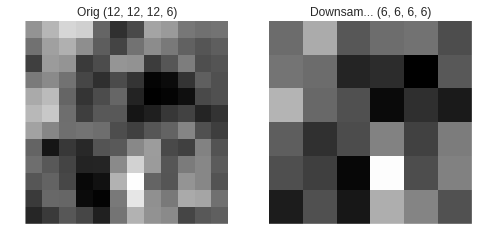

In [5]:
img_shape = img_lr.shape
x0,xf, y0,yf, z0,zf = volume_range_lr = (10, 16, 15, 21, 15, 21)
b0, bf = bval_range = (10,16)
gdirections = lr_hr_img.gtab.bvecs[b0:bf]

# Type and intensiti of noise to apply
SNR, SNR_TYPE = 25, 'gaussian'

#img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf] = (img_hr[2*x0:2*xf, y0, 2*z0:2*zf, b0:bf].max())*np.ones((12,12,12,6))

i_lr = img_lr[x0:xf, y0:yf, z0:zf, b0:bf]
i_hr = img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf]

img_utils._isc(i_hr,i_lr,titles=['Orig '+ str(i_hr.shape), 'Downsam... '+str(i_lr.shape)] )
'b=2000, G directions =', gdirections

# Estimate G with machine learning

In [6]:
import utils.RandomRanges as rr
import utils.DmriVolumesRandomIndexers as ixs
import utils.DmriSampleCreators as sc
import utils.ml.MLDataBuilder as db


# Estrategia de volumne y rango de bvals (fija)
volume_strategy, bval_strategy = rr.Fixed3DRange(*volume_range_lr), rr.Fixed1DRange(*bval_range)
# El que combina ambas
dmri_volume_indexer = ixs.DmriVolumeRandomIndexer(volume_strategy, bval_strategy)
# Equivalencia entre indices de la hr y lr 
fconvert = lambda *lr_tuple : tuple(np.array(lr_tuple[:-2])*2)+lr_tuple[-2:]
# Iterador de dmri imagen lr y hr
lr_hr_vol_it = ixs.DmriLrHrCubicPatchVolumeRandomIndexer(dmri_volume_indexer, fconvert, from_lr2hr=True)

# El que toma la imagen original y downsampleada y les pone ruido (gaussian, rician)
sample_creator = sc.NoisedLrHrDmriSampleCreator(lr_hr_img, lr_hr_vol_it, snr=SNR, noise_type=SNR_TYPE)


n_samples = 10

# Builder that organize data like the ML wants 
sdb = db.SimpleMlDataBuilder(sample_creator, n_samples)

X, Y = sdb.build()
print X.shape, Y.shape

Samples for  standfor_hardi_labels : 10 of inf
(1296, 10) (10368, 10)


In [7]:
from scipy.sparse import csr_matrix, csc_matrix
import experimento1_funciones as e1f
#reload(e1f)

# Calculamos la matriz de downsampling
regr, Y_train , X_train, Y_test, X_test = e1f.train(Y,X)

regr.coef_ = csr_matrix(regr.coef_)
type(regr.coef_), regr.coef_.shape, SNR

Training set_training.shape= (10368, 9)  ->target.shape= (1296, 9)


(scipy.sparse.csr.csr_matrix, (1296, 10368), 25)

# Problem definition

$ \min_{Y_{hr}} \{ ||GY_{lr} - Y_{hr}||^2 \}$ st $Y_{hr} \geq 0$

In [8]:
Nx, Ny, Nz, bval = i_hr.shape
vhrb = Nx*Ny*Nz*bval
vlr = Nx*Ny*Nz/8

Yhr = cvx.Variable(vhrb, 1)
Ylr = i_lr.reshape((vlr*bval, 1))
G = cvx.Parameter(*regr.coef_.shape, value=regr.coef_)

# Form objective.
obj = cvx.Minimize(cvx.sum_squares(G*Yhr - Ylr))

# Create two constraints.
#constraints = [Yhr >= 0]

# Form and solve problem.
prob = cvx.Problem(obj)
prob, prob.is_dcp()

(Problem(Minimize(Expression(CONVEX, POSITIVE, (1, 1))), []), True)

In [9]:
start_time = time.time()

res = prob.solve(solver='SCS',verbose=True, max_iters=2100,eps=1.00e-01 )  # Returns the optimal value.

print "status:", prob.status
print "optimal value", prob.value
#print "optimal var", Yhr.value

seg = time.time() - start_time
minutes = int(seg / 60)
print("--- time of optimization : %d' %d'' --- num. snr: %d" % (minutes , seg%60, SNR))

WARN: m less than n, problem likely degenerate
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 13436930, CG tol ~ 1/iter^(2.00)
eps = 1.00e-01, alpha = 1.50, max_iters = 2100, normalize = 1, scale = 1.00
Variables n = 10369, constraints m = 1298
Cones:	soc vars: 1298, soc blks: 1
Setup time: 7.43e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.84e+00  5.01e-01  1.00e+00 -3.21e+04  1.92e+01  0.00e+00  8.30e-01 
   100| 2.30e-02  1.98e-05  5.21e-01  1.26e+02  4.03e+02  7.30e-10  2.00e+01 
   200| 1.77e-02  1.10e-05  4.37e-01  2.27e+02  5.81e+02  7.34e-10  4.20e+

In [11]:
A = np.asarray(Yhr.value).reshape(i_hr.shape)
print 'shape=', A.shape, SNR


shape= (12, 12, 12, 6) 25


# Tractografy on original data

(12, 12, 12)
(12, 12, 12) y= 6


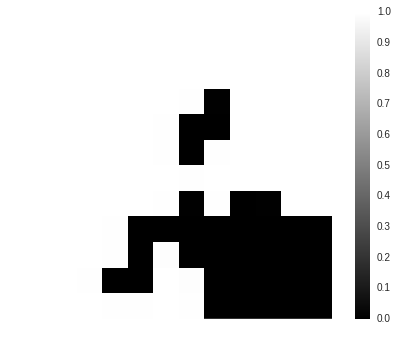

In [31]:
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere, GradientTable
from dipy.direction import peaks_from_model

white_matter = (labels == 1) | (labels == 2)
i_wm =  white_matter[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf]
print i_wm.shape

img_utils._is(i_wm)

gtab_small = GradientTable(gtab.gradients[b0:bf],  big_delta=gtab.big_delta, 
                           small_delta=gtab.small_delta, b0_threshold=gtab.b0_threshold)

csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, img_hr, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)


### Clasifyer

In [32]:
from dipy.tracking.local import ThresholdTissueClassifier

classifier = ThresholdTissueClassifier(csa_peaks.gfa, .25)

### Seeds

In [36]:
from dipy.tracking import utils

affine = lr_hr_img.get_lr_affine()
seed_mask = labels == 2
seeds = utils.seeds_from_mask(seed_mask, density=[2, 2, 2], affine=affine)

### Trackin and show

In [38]:
from dipy.tracking.local import LocalTracking
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

# Initialization of LocalTracking. The computation happens in the next step.
streamlines = LocalTracking(csa_peaks, classifier, seeds, affine, step_size=.5)

# Compute streamlines and store as a list.
streamlines = list(streamlines)

# Prepare the display objects.
color = line_colors(streamlines)

if fvtk.have_vtk:
    streamlines_actor = fvtk.line(streamlines, line_colors(streamlines))

    # Create the 3d display.
    r = fvtk.ren()
    fvtk.add(r, streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    # fvtk.show , vtk.record
    #fvtk.show(r, n_frames=1, out_path='deterministic.png',
    #            size=(800, 800))
    fvtk.show(r)

# Tracking of reconstructed

In [40]:
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere, GradientTable
from dipy.direction import peaks_from_model

white_matter = (labels == 1) | (labels == 2)
i_wm =  white_matter[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf]
print i_wm.shape


img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf] = A

#img_utils._is(i_wm)

gtab_small = GradientTable(gtab.gradients[b0:bf],  big_delta=gtab.big_delta, 
                           small_delta=gtab.small_delta, b0_threshold=gtab.b0_threshold)

csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, img_hr, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)


(12, 12, 12)


### Clasifyer

In [41]:
from dipy.tracking.local import ThresholdTissueClassifier

classifier = ThresholdTissueClassifier(csa_peaks.gfa, .25)

### Seeds

In [42]:
from dipy.tracking import utils

affine = lr_hr_img.get_lr_affine()
seed_mask = labels == 2
seeds = utils.seeds_from_mask(seed_mask, density=[2, 2, 2], affine=affine)

### Trackin and show

In [ ]:
from dipy.tracking.local import LocalTracking
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

# Initialization of LocalTracking. The computation happens in the next step.
streamlines = LocalTracking(csa_peaks, classifier, seeds, affine, step_size=.5)

# Compute streamlines and store as a list.
streamlines = list(streamlines)

# Prepare the display objects.
color = line_colors(streamlines)

if fvtk.have_vtk:
    streamlines_actor = fvtk.line(streamlines, line_colors(streamlines))

    # Create the 3d display.
    r = fvtk.ren()
    fvtk.add(r, streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    # fvtk.show , vtk.record
    #fvtk.show(r, n_frames=1, out_path='deterministic.png',
    #            size=(800, 800))
    fvtk.show(r)
        